# Reservoir Operations Spain - attributes
***

**_Autor:_** Chus Casado Rodríguez<br>
**_Fecha:_** 15-03-2024<br>

**Introduction:**<br>
This code compares the available attributes for reservoirs in Spain from different sources: the Spanish Ministry, ICOLD, GRanD.

**To be checked:**<br>
* [ ] The field `cedex_dam.Qspill_EFL` is mostly empty.
* [x] There's a erroneous reservoir in EFAS. "El Alisillo" (ResID=3247) does not refer to any real reservoir, but it's very closely located to the "Montoro III" reservoir. The attributes don't much, though, so it's not a matter of just renaming the reservoir. <font color='steelblue'>I have created a new reservoir to represent "Montoro III"</font>.
* [ ] How to proceed when there are several reservoirs in a continuous chain. For instance, Torrejón-Tajo and Arrocampo, or Tanes and Rioseco. Should we simulate each of them, or simply simulate them as a single reservoir with the aggregated volume?
* [x] Attributes from GRanD
* [x] Compare attributes among data sources: reservoir volume, etc.
* [x] Should I include in the tables of attributes only the reservoirs with time series, or all the reservoirs? <font color='steelblue'>I have included all the reservoirs, so they can be later on used for regionalization, i.e., to estimate their reservoir parameters based on the attributes even though there aren't records.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from shapely.geometry import Point
import re
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
sns.set_style('ticks')

from utils.SNCZI import reservoir_attributes, dam_attributes

In [2]:
# import unidecode

In [3]:
def remove_accents(string: str) -> str:
    
    string = re.sub(r'[ÁáÀà]', 'A', string)
    string = re.sub(r'[Éé]', 'E', string)
    string = re.sub(r'[Íí]', 'I', string)
    string = re.sub(r'[Óó]', 'O', string)
    string = re.sub(r'[Úú]', 'U', string)

    return string

## Configuration

In [4]:
path_datasets = Path('Z:/nahaUsers/casadje/datasets')

path_ResOpsES = path_datasets / 'reservoirs' / 'ResOpsES'

path_out = path_ResOpsES / 'attributes'
path_out.mkdir(parents=True, exist_ok=True)

In [5]:
path_snczi = path_datasets / 'SNCZI' / 'reports' 

## Reservoirs

**Anuario de Aforos**

Import shapefile of reservoirs in the Hydrological Data Colection Center (HDCC) database.

In [6]:
path_cedex = path_datasets / 'CEDEX' / 'processed' / 'reservoirs'
reservoirs_AA = gpd.read_file(path_cedex / 'attributes' / 'GIS' / 'reservoirs.shp')
reservoirs_AA.ref_ceh = reservoirs_AA.ref_ceh.astype('Int64')
reservoirs_AA.rename(columns={'nombre': 'name', 'ref_ceh': 'ID'}, inplace=True)
reservoirs_AA['SNCZI'] = reservoirs_AA['SNCZI'].replace(0, np.nan).astype('Int64')
reservoirs_AA.set_index('SNCZI', drop=True, inplace=True)
reservoirs_AA.sort_index(axis=0, inplace=True)

print('Anuario de Aforos contains {0} reservoirs'.format(reservoirs_AA.shape[0]))
print('{0} reservoirs are not connected to the SNCZI database'.format((reservoirs_AA.index.isnull()).sum()))
# reservoirs_AA.head()

Anuario de Aforos contains 394 reservoirs
7 reservoirs are not connected to the SNCZI database


**Agència Catalana de l'Aigua**

I have downloaded reservoir records from the ACA website, but these reservoirs are not yet in HDCC. I will upload here the shapefile of the ACA reservoirs and concatenate it to HDCC.

In [7]:
# load shapefile and treat the data
reservoirs_aca = gpd.read_file(path_datasets / 'ACA' / 'processed' / 'reservoirs' / 'attributes' / 'GIS' / 'reservoirs_ACA.shp')
reservoirs_aca.set_index('SNCZI', inplace=True, drop=True)
reservoirs_aca.rename(columns={'ID_ACA': 'ID'}, inplace=True)

print('ACA contains {0} reservoirs'.format(reservoirs_aca.shape[0]))
print('{0} reservoirs are not connected to the SNCZI database'.format((reservoirs_aca.index.isnull()).sum()))
# reservoirs_aca.head()

ACA contains 13 reservoirs
1 reservoirs are not connected to the SNCZI database


**Hidrosur**

I have requested reservoir data from Hidrosur. This data is not yet in HDCC, so I will load it here and combine it with the reservoirs in HDCC.

In [8]:
# load shapefile and treat the data
reservoirs_sur = gpd.read_file(path_datasets / 'Hidrosur' / 'processed' / 'reservoirs' / 'attributes' / 'GIS' / 'reservoirs_hidrosur.shp')
reservoirs_sur['SNCZI'] = reservoirs_sur['SNCZI'].astype('Int64')
reservoirs_sur.set_index('SNCZI', drop=True, inplace=True)

print('Hidrosur contains {0} reservoirs'.format(reservoirs_sur.shape[0]))
print('{0} reservoirs are not connected to the SNCZI database'.format((reservoirs_sur.index.isnull()).sum()))
# reservoirs_sur.head()

Hidrosur contains 21 reservoirs
0 reservoirs are not connected to the SNCZI database


**Merge all**

<font color='indianred'>I remove the reservoirs without SNCZI code.</font>

Anuario + ACA + Hidrosur:	427 reservoirs
8 reservoirs are not connected to the SNCZI database


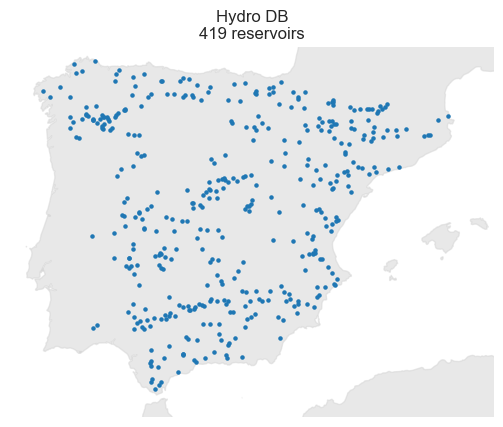

In [9]:
cols = ['ID', 'name', 'geometry']
hdcc = pd.concat((reservoirs_AA[cols], reservoirs_aca[cols], reservoirs_sur[cols]), axis=0)
hdcc.index = hdcc.index.astype('Int64')
# remove one of the instances of the Siurana reservoir (included both in Anuario and ACA)
# I remove the instance in the ACA (`ID == 'E18')
hdcc = hdcc.loc[hdcc.ID != 'E18']
hdcc.name = hdcc.name.str.replace(r'(.+), (.+)', r'\2 \1', regex=True)
# hdcc.name = hdcc.name.apply(unidecode.unidecode)
hdcc.name = [remove_accents(name) for name in hdcc.name]

print('Anuario + ACA + Hidrosur:\t{0} reservoirs'.format(hdcc.shape[0]))
print('{0} reservoirs are not connected to the SNCZI database'.format((hdcc.index.isnull()).sum()))

hdcc = hdcc.loc[~(hdcc.index.isnull())]

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
hdcc.plot(markersize=5, ax=ax)
ax.set_title(f'Hydro DB\n{hdcc.shape[0]} reservoirs')
ax.set_extent([-10, 4.5, 35.5, 44])
ax.axis('off');

## CEDEX

In [10]:
path_snczi = path_datasets / 'SNCZI' / 'reports'

### Reservoir attributes

There are several attributes of interest in this table:

* Coordinates.
* Reservoir volume: both total and live volume.
* Reservoir area.
* Design reservoir levels.


In [11]:
# load individal XML for each reservoir
cedex_res = pd.DataFrame(dtype='object')
for file in tqdm(list((path_snczi / 'reservoirs').glob('*.xml'))):
    ID = int(file.stem)
    try:
        cedex_res = pd.concat((cedex_res, reservoir_attributes(str(file), name=ID)), axis=1)
    except:
        print(f'File {file} could not be read')
cedex_res = cedex_res.transpose()
cedex_res.index.name = 'SNCZI'
cedex_res['Código del embalse'] = cedex_res['Código del embalse'].astype(int)

# rename columns
rename_cols = {'Código del embalse': 'res_ID',
               'Nombre del embalse': 'res_name',
               'Titular del embalse': 'owner',
               'Coord. X ETRS89': 'lon', # longitude
               'Coord. Y ETRS89': 'lat', # latitud
               'Coord. X UTM ETRS89 Huso 30': 'X',
               'Coord. Y UTM ETRS89 Huso 30': 'Y',
               'Coord. X Manual': 'X_manual',
               'Coord. Y Manual': 'Y_manual',
               'Volumen útil (m3)': 'V_live',
               'Volumen total (m3)': 'V_total',
               'Superficie del embalse (has)': 'AREA',
               'Máximo nivel de avenida (m)': 'EFL', # Extreme Flood Level
               'Máximo nivel normal del embalse (m)': 'MNL', # Maximum Normal Level
               'Municipio': 'town', 
               # 'Id. Hoja 1:50.000',
               'Cauce': 'river', 
               'Código de infraestructura': 'inf_ID', 
               'Nombre de la presa': 'dam_name'}
cedex_res.rename(columns=rename_cols, inplace=True)

# convert reservoir area to km2
cedex_res.AREA /= 100

print('Imported from SNCZI {0} reservoirs and {1} attributes'.format(*cedex_res.shape))

  0%|          | 0/419 [00:00<?, ?it/s]

Imported from SNCZI 419 reservoirs and 19 attributes


### Dam attributes

This dataset contains multiple attributes of interes:

* Date of construction.
* Coordinates.
* Reservoir use.
* Catchment area.
* Reservoir level, surface and volume at the maximum normal level (MNL).
* Elevation of river, foundation, crest.
* Number of outlets (spillways and sluices) and their discharge capacity.

In [12]:
# shapefile of dams in the Spanish inventory
dams_SNCZI = gpd.read_file(path_cedex / 'attributes' / 'GIS' / 'egis_presa_geoetrs89.shp')
cols_int = ['ID_INFRAES', 'CODIGO']
dams_SNCZI[cols_int] = dams_SNCZI[cols_int].astype(int)
dams_SNCZI.set_index('ID_INFRAES', drop=True, inplace=True)
dams_SNCZI.sort_index(inplace=True)
dams_SNCZI.to_crs(epsg=25830, inplace=True)

print('SNCZI contains {0} dams and {1} attributes'.format(*dams_SNCZI.shape))
# dams_SNCZI.head()

SNCZI contains 3208 dams and 23 attributes


In [13]:
# load individal XML for each dam
cedex_dam = pd.DataFrame(dtype='object')
for file in tqdm(list((path_snczi / 'dams').glob('*.xml'))):
    dam_ID = int(file.stem)
    code_infr = dams_SNCZI.loc[dam_ID, 'CODIGO']
    ID = cedex_res.loc[cedex_res.inf_ID == code_infr].index[0]
    try:
        cedex_dam = pd.concat((cedex_dam, dam_attributes(str(file), name=ID)), axis=1)
    except:
        print(f'File {file} could not be read')
cedex_dam = cedex_dam.transpose()
cedex_dam.index.name = 'SNCZI'

# rename columns
rename_cols = {'Nombre de la presa': 'dam_name',
               'Otro Nombre': 'other_name',
               'Fase vida presa': 'phase',
               'Titular de la presa': 'owner',
               'Proyectista': 'designer',
               'Categoría en función del riesgo potencial': 'category',
               'Aprobación de las normas de explotación': 'date_exploitation_plan',
               'Aprobación del plan de emergencia': 'date_emergency_plan',
               'Fecha de finalización de las obras': 'date_construction',
               'Río en el que se encuentra la presa': 'river', 
               'Municipio': 'town',
               'Cuenca hidrográfica': 'basin', 
               'Provincia': 'province', 
               'X-UTM30ETRS89': 'X', 
               'Y-UTM30ETRS89': 'Y',
               'Usuarios': 'users', 
               'Tipos': 'use', 
               'Superficie de la cuenca hidrográfica (km2)': 'catch_area',
               'Aportación media anual (hm3)': 'inflow', 
               'Precipitación media anual (mm)': 'precip',
               'Caudal punta avenida de proyecto (m3/s)': 'Q_design',
               'Superficie del embalse a NMN (ha)': 'A_MNL', # Nivel Máximo Normal => Maximum Normal Level
               'Capacidad a NMN (hm3)': 'V_MNL',
               'Cota del NMN (m)': 'Z_MNL', 
               'Tipo de presa': 'type', 
               'Cota coronación (m)': 'Z_crest',
               'Altura desde cimientos (m)': 'height', 
               'Longitud de coronación (m)': 'len_crest',
               'Cota cimentación (m)': 'Z_foundation', 
               'Cota del cauce en la presa (m)': 'Z_river',
               'Volumen del cuerpo presa (1000 m3)': 'dam_vol',
               'Número total de aliviaderos en la presa': 'no_spill', 
               'Regulación': 'regulation',
               'Capacidad a NAE (m3/s)': 'Qspill_EFL', # Nivel de Avenida Extrema => Extreme Flood Level
               'Número total de desagües en la presa': 'no_sluice',
               'Capacidad (m3/s)': 'Qsluice'}
cedex_dam.rename(columns=rename_cols, inplace=True)

# convert to date
for col in cedex_dam.columns[cedex_dam.columns.str.startswith('date')]:
    cedex_dam[col] = pd.to_datetime(cedex_dam[col], format='%d-%m-%Y', errors='coerce')

# convert reservoir area to km2
cedex_dam.A_MNL /= 100

print('Imported from SNCZI {0} dams and {1} attributes'.format(*cedex_res.shape))

  0%|          | 0/417 [00:00<?, ?it/s]

Imported from SNCZI 419 dams and 19 attributes


#### Reservoir use

**Create individual colums for each use**

I convert the `use` column into a one hot encoder.

In [14]:
# analyse reservoir use:
# 1. I will suppose that the the first use in the dataset is the `main_use`
# 2. I create a `single_use` field to identify single-purpose and multipurpose reservoirs
# 3. I create a one hot encoder class with all the possible reservoir uses

cedex_dam.use = cedex_dam.use.replace(np.nan, '')
rename_uses_cedex = {'': 'other',
                     'Abastecimiento': 'supply',
                     'Acuicultura': 'fish',
                     'Adecuación ambiental': 'environment',
                     'Defensa frente avenidas': 'flood',
                     'Ganadero': 'livestock',
                     'Hidroeléctrico': 'hydropower',
                     'Industrial': 'industry',
                     'Minería': 'mining',
                     'Recreo': 'recreation',
                     'Regulación': 'regulation',
                     'Riego': 'irrigation',
                     'Trasvase': 'diversion'}

cedex_dam['main_use'] = ''
cedex_dam['single_use'] = True
cedex_uses = list(rename_uses_cedex.values())
# cedex_uses.remove('')
cedex_uses.sort()
cedex_dam[cedex_uses] = False
for ID in cedex_dam.index:
    uses_i = cedex_dam.loc[ID, 'use'].split('. ')
    # if '' in uses_i:
    #     uses_i.remove('')
    if len(uses_i) > 0:
        for i, use in enumerate(uses_i):
            use = rename_uses_cedex[use]
            if i == 0:
                cedex_dam.loc[ID, 'main_use'] = use
            cedex_dam.loc[ID, use] = True

# identify multi-purpose reservoirs
mask_multiuse = cedex_dam[cedex_uses].sum(axis=1) > 1
cedex_dam.loc[mask_multiuse, 'single_use'] = False

# remove original 'use' field
# cedex_dam.drop('use', axis=1, inplace=True)

**Main use**

In [15]:
mainuse_singlepurpose = cedex_dam.loc[cedex_dam.single_use, 'main_use'].value_counts()
mainuse_multipurpose = cedex_dam['main_use'].value_counts()
mainuse_summary_cedex = pd.concat((mainuse_singlepurpose, mainuse_multipurpose), axis=1)
mainuse_summary_cedex.columns = ['singlepurpose', 'multipurpose']
mainuse_summary_cedex.sort_values('multipurpose', ascending=False, inplace=True)
del mainuse_singlepurpose, mainuse_multipurpose

**All uses**

In [16]:
alluses_singlepurpose = cedex_dam.loc[cedex_dam.single_use, cedex_uses].sum()
alluses_multipurpose = cedex_dam[cedex_uses].sum()
alluses_summary_cedex = pd.concat((alluses_singlepurpose, alluses_multipurpose), axis=1)
alluses_summary_cedex.columns = ['singlepurpose', 'multipurpose']
alluses_summary_cedex.sort_values('multipurpose', ascending=False, inplace=True)
alluses_summary_cedex.dropna(axis=0, how='all', inplace=True)
alluses_summary_cedex = alluses_summary_cedex[~(alluses_summary_cedex == 0).all(axis=1)]
del alluses_singlepurpose, alluses_multipurpose

**Classify hydropower reservoirs**

I will create a field called `HP_type` (hydropower type) to specify the importance of the hydropower use among all the uses of that reservoir. Codes:

* 0: single purpose hydropower.
* 1: multi-purpose in which hydropower is the main use.
* 2: multi-purpose in which hydropower is the second use.
* 3: multi-purpose in which hydropower is the third use.
* N: multi-purpose in which hydropower is the Nth use.

```Python
cedex_dam['HP_type'] = np.nan

cedex_dam.loc[cedex_dam.single_use & cedex_dam.hydropower, 'HP_type'] = 0

for ID in cedex_dam.loc[cedex_dam.hydropower].index:
    if cedex_dam.loc[ID, 'single_use']:
        continue
    uses = [rename_uses_cedex[use] for use in cedex_dam.loc[ID, 'use'].split('. ')]
    if 'hydropower' in uses:
        cedex_dam.loc[ID, 'HP_type'] = uses.index('hydropower') + 1

cedex_dam.HP_type.value_counts()
 ```

**Total annual volume outflow (hm3)**

```Python
outflows = pd.DataFrame(dtype=float)
for ID in tqdm(cedex_dam.loc[cedex_dam.hydropower].index):
    
    # load time series
    df = pd.read_csv(path_cedex / 'timeseries' / f'{ID}.csv', index_col='date')
    df.index = pd.to_datetime(df.index)
    if 'outflow' not in df.columns:
        continue
    
    # compute annual total flow
    outflow_y = df.loc[datetime(2010, 1, 1): datetime(2019, 12, 31), 'outflow'].resample('y').mean() * 365 * 24 * 3600 / 1e6
    outflow_y.index = [f'outflow_{idx.year}' for idx in outflow_y.index]
    outflow_y = outflow_y.to_frame(ID)
    
    # concatenate
    outflows = pd.concat((outflows, outflow_y), axis=1)
```

### Connect HDCC and CEDEX
The connection is direct using the common `SNCZI` index in both the HDCC and CEDEX data sets.

### Export

In [17]:
# columns to be used from the inventory of dams in CEDEX
cols_cedex_dam = ['date_construction',
                  # catchment hydrology
                  'catch_area', 'inflow', 'precip', 'Q_design', 
                  # reservoir geometry
                  'A_MNL', 'V_MNL', 'Z_MNL', 'Z_crest', 'height', #'dam_vol', 
                  # reservoir regulation
                  'no_spill', 'Qspill_EFL', 'regulation', 'no_sluice', 'Qsluice',
                  # reservoir use
                  'main_use', 'single_use', 'fish', 'diversion', 'environment', 'flood', 'hydropower', 'industry', 'irrigation', 'livestock',
                  'mining', 'other', 'recreation', 'supply']

# columns to be used from the inventory of reservoirs in CEDEX
cols_cedex_res = ['V_live', 'V_total', 'AREA', 'EFL', 'MNL']

# combine attributes from HDCC and CEDEX
attributes_cedex = pd.concat((hdcc[cols], cedex_dam[cols_cedex_dam], cedex_res[cols_cedex_res]), axis=1)#.sort_index(axis=1)

# attributes
attributes_cedex.to_csv(path_out / 'attributes_CEDEX.csv')

## Hydropower Data Base (HPDB)

```Python
hpdb = pd.read_excel(path_datasets / 'reservoirs' / 'HPDB' / 'HPDB_Spain.xlsx', index_col='HPDB_id')
hpdb.Name = hpdb.Name.str.upper()
# # correct coordinates of "La Muela"
# hpdb.loc['H4', ['Longitude', 'Latitude']] = [-0.92821, 39.23821]

# rename columns
rename_cols = {#'Name',
               # 'country',
               'Longitude': 'lon',
               'Latitude': 'lat',
               'HPDB_installed_capacity_MW': 'instal_cap',
               'HPDB_pumping  capacity if it is a HPHS_MW': 'pump_cap',
               'HPDB_type': 'type',
               'HPDB_head_m': 'head_HPDB',
               'head': 'head_src2',
               'dam height (match from ICOLD o Vattenfal for Sweden)': 'dam_height',
               'head (final)': 'head',
               'HPDB_volume_Mm3': 'vol_HPDB',
               'HPDB_volume_from ICOLD_Mm3': 'vol_ICOLD',
               'HPDB_volume of reservoir_final_Mm3': 'volume',
               'final energy generation GWh': 'energy',
               'Annual volume discharged (a bit underestimated, because the used head is the maximum one) Mm3': 'vol_turb'
              }
hpdb.rename(columns=rename_cols, inplace=True)

# filter dam hydropower plants
hpdb = hpdb.loc[hpdb.type == 'HDAM']

# convert into GeoDataFrame
geometry = [Point(xy) for xy in zip(hpdb.lon, hpdb.lat)]
hpdb = gpd.GeoDataFrame(hpdb, geometry=geometry, crs='epsg:4326')

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
hpdb.plot(markersize=5, ax=ax)
ax.set_title(f'Hydropower Batabase\n{hpdb.shape[0]} reservoirs')
ax.set_extent([-10, 4.5, 35.5, 44])
ax.axis('off');
```

**Connect HPDB with HDCC**

```Python
# nearest neighbour in ICOLD for each point in HDCC
idx_hpdb, idx_hdcc = hdcc.sindex.nearest(hpdb.geometry, max_distance=.1)

# add ICOLD name and ID to the HDCC table
hpdb.drop(['HDCC_ID', 'HDCC_Name'], axis=1, inplace=True, errors='ignore')
idx_hpdb = hpdb.index[idx_hpdb]
hpdb.loc[idx_hpdb, 'HDCC_ID'] = hdcc.iloc[idx_hdcc].index.values
hpdb.loc[idx_hpdb, 'HDCC_Name'] = hdcc.iloc[idx_hdcc]['Name'].values

(hpdb.Name == hpdb.HDCC_Name).sum()

mask_name = hpdb.Name != hpdb.HDCC_Name
hpdb.loc[mask_name, ['Name', 'HDCC_Name']].sort_values('Name').head(30)

for col in hpdb.columns:
    if len(col) > 10:
        print(col)

hpdb.to_file(path_datasets / 'reservoirs' / 'HPDB' / 'HPDB_Spain.shp')

for ID in cedex_dam.index:
    name = cedex_dam.loc[ID, 'dam_name']
    if 'MUELA' in name:
        print(ID, name)
```

## ICOLD

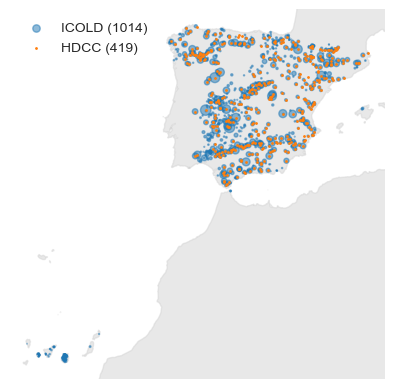

In [34]:
# import shapefile
icold = gpd.read_file(path_datasets / 'reservoirs/ICOLD/2023/ICOLD_ES.shp')
icold.reset_index(drop=True, inplace=True)

# remove duplicated entries keeping the heights dam associated to each reservoir
for name, count in icold.Res_Name.value_counts().items():
    if count > 1:
        remove_idx = icold.loc[icold.Res_Name == name].sort_values('Height', ascending=False).index[1:]
        icold.drop(remove_idx, axis=0, inplace=True)
    else:
        break
        
# remove entries without geometry
icold.drop([idx for idx, geo in icold.geometry.items() if geo is None], axis=0, inplace=True)
        
# convert reservoir volume MCM (hm3)
icold.Res_Vol /= 1000

# convert reservoir area to km2
icold.Res_Area /= 1000

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
icold.plot(markersize=icold.Res_Vol**.5, alpha=.5, ax=ax, label=f'ICOLD ({icold.shape[0]})')
hdcc.plot(markersize=1, ax=ax, label=f'HDCC ({hdcc.shape[0]})')
# ax.set_extent([-10, 4.5, 35.5, 44])
ax.legend(frameon=False)
ax.axis('off');

# mask_volume = icold_es.Res_Vol > 10
# print(f'no. reservoirs in Spain with V > 10 hm3:\t{mask_volume.sum()}')

### Connect HDCC and ICOLD

<font color='indianred'>Do the match by name first!</font>

In [35]:
from fuzzywuzzy import process
from geopy.distance import geodesic

In [35]:
icold[['SNCZI', 'CEDEX_name']] = np.nan
for snczi, name in tqdm(hdcc.name.items()):
    
    one = process.extractOne(name, icold.Res_Name, score_cutoff=90)

    if one is None:
        continue

    # compute distance
    point1 = hdcc.loc[hdcc.name == name].geometry.iloc[0]
    point2 = icold.loc[icold.Res_Name == one[0]].geometry.iloc[0]
    dist = geodesic((point1.y, point1.x), (point2.y, point2.x)).meters
    if dist < 1e4:
        icold.loc[icold.Res_Name == one[0], ['SNCZI', 'CEDEX_name']] = snczi, name
        
print('{0} matches found'.format((~icold.SNCZI.isnull()).sum()))

0it [00:00, ?it/s]

405 matches found


In [38]:
# nearest neighbour in ICOLD for each point in HDCC
# mask_hdcc = hdcc.index.difference(icold.SNCZI)
# mask_icold = icold.SNCZI.isnull()
# idx_icold, idx_hdcc = hdcc.loc[mask_hdcc].sindex.nearest(icold.loc[mask_icold].geometry, max_distance=.05)
# idx_hdcc = hdcc.loc[mask_hdcc].index[idx_hdcc]
# idx_icold = icold.loc[mask_icold].index[idx_icold]
# print(f'matches:\t{len(idx_hdcc)} (out of {len(mask_hdcc)}) reservoirs')

# # add ICOLD name and ID to the HDCC table
# icold.loc[idx_icold, 'SNCZI'] = idx_hdcc.values
# icold.loc[idx_icold, 'CEDEX_name'] = hdcc.loc[idx_hdcc, 'name'].values

In [39]:
# # remove SNCZI from reservoirs whose name in ICOLD and HDCC doesn't match
# mask_name = icold.Res_Name != icold.CEDEX_name
# mask_id = ~icold.SNCZI.isnull()
# icold.loc[mask_name & mask_id, 'SNCZI'] = np.nan

In [41]:
# convert 'Local_ID' to integer
icold.SNCZI = icold.SNCZI.astype('Int64')

### Reservoir use

In [45]:
# count uses
uses = []
for ID in icold.index:
    try:
        uses = uses + list(icold.loc[ID, 'Purposes'])
    except:
        continue

np.unique(uses, return_counts=True)

(array(['C', 'H', 'I', 'R', 'S', 'T', 'X'], dtype='<U1'),
 array([ 42, 334, 477,   9, 391,   3,  86], dtype=int64))

In [46]:
rename_uses = {'C': 'flood',
               'I': 'irrigation',
               'H': 'hydropower',
               'F': 'fish',
               'N': 'navigation',
               'R': 'recreation',
               'S': 'supply',
               'X': 'other',
               'T': 'tailings'}

icold['main_use'] = ''
icold['single_use'] = True

icold_uses = list(rename_uses.values())
icold_uses.sort()
icold[icold_uses] = False

for ID in icold.index:
    if icold.loc[ID, 'Purposes'] is None:
        continue
    for i, key in enumerate(icold.loc[ID, 'Purposes']):
        use = rename_uses[key]
        if i == 0:
            icold.loc[ID, 'main_use'] = use
        icold.loc[ID, use] = True

# identify multi-purpose reservoirs
mask_multipurpose = icold[icold_uses].sum(axis=1) > 1
icold.loc[mask_multipurpose, 'single_use'] = False

# # remove original 'Purposes' field
# icold.drop('Purposes', axis=1, inplace=True)

**Main use**

In [47]:
mask_singleuse = icold.single_use
mask_hdcc = ~icold.SNCZI.isnull()
mainuse_singlepurpose = icold.loc[mask_hdcc & mask_singleuse, 'main_use'].value_counts()
mainuse_multipurpose = icold.loc[mask_hdcc, 'main_use'].value_counts()
mainuse_summary_icold = pd.concat((mainuse_singlepurpose, mainuse_multipurpose), axis=1)
mainuse_summary_icold.columns = ['singlepurpose', 'multipurpose']
mainuse_summary_icold.sort_values('multipurpose', ascending=False, inplace=True)
del mainuse_multipurpose, mainuse_singlepurpose

**All uses**

In [48]:
alluses_singlepurpose = icold.loc[mask_hdcc & mask_singleuse, icold_uses].sum()
alluses_multipurpose = icold.loc[mask_hdcc, icold_uses].sum()
alluses_summary_icold = pd.concat((alluses_singlepurpose, alluses_multipurpose), axis=1)
alluses_summary_icold.columns = ['singlepurpose', 'multipurpose']
alluses_summary_icold.sort_values('multipurpose', ascending=False, inplace=True)
alluses_summary_icold.dropna(axis=0, how='all', inplace=True)
alluses_summary_icold = alluses_summary_icold[~(alluses_summary_icold == 0).all(axis=1)]
del alluses_singlepurpose, alluses_multipurpose

### Export

Interesting attributes in ICOLD:

* Altitude.
* Catch_area. Compare with CEDEX.
* Crest_Leng. Compare with CEDEX.
* Elec_Capac.
* Ene_Annual.
* Height.
* Irr_Area.
* Purposes
* Res_Area. Compare with CEDEX.
* Res_Leng.
* Res_Vol. Compare with CEDEX.
* Spill_Cap. Compare with CEDEX.
* Spill_type.
* Vol_flood.
* Year.

In [49]:
# attributes to be included from ICOLD
cols_icold = ['Altitude', 'Catch_Area', 'Crest_Leng', 'Dam_Name',
              'Elec_Capac', 'Ene_Annual',
              'Foundation', 'Height',
              'Irr_Area', 
              'Latitude', 'Longitude',
              'Res_Area', 'Res_Leng', 'Res_Name', 'Res_Vol', 'Resettled',
              'Spill_Cap', 'Spill_Type', 'Vol_flood', 'Year',
              'main_use', 'single_use', 'fish', 'flood', 'hydropower', 'irrigation', 'navigation', 'other', 'recreation', 'supply', 'tailings']

# export attribute table
icold.loc[~icold.index.isnull(), cols_icold].to_csv(path_out / 'attributes_ICOLD.csv')
# icold[cols_icold].to_csv(path_out / 'attributes_ICOLD.csv')

## EFAS

In [50]:
path_EFAS = Path('Z:/nahaUsers/casadje/EFASv5/reservoirs/')

### Shapefile

In [51]:
# load EFAS reservoirs
efas = gpd.read_file(path_EFAS / 'reservoirs_EFAS5.shp')
efas.ResID = efas.ResID.astype(pd.Int64Dtype())
efas.set_index('ResID', inplace=True)

# filter reservoir in Spain
efas = efas.loc[efas.COUNTRY == 'Spain']

# correct dam names
efas.DAM_NAME.replace(np.nan, '', inplace=True)
names = []
for name in efas.DAM_NAME.str.upper():
    split = name.split('_')
    if len(split) == 2:
        names.append(split[0])
    elif len(split) > 2:
        names.append(' '.join(split[:-1]))
    else:
        names.append(name)
efas.DAM_NAME = names

# correct coordinates of Cenza reservoir
# efas.loc[3132, ['LON_ORG', 'LAT_ORG']] = [-7.1442, 42.1141]

# remove old reservoir "El Alisillo" (ResID = 3247)
efas.drop([3247], axis=0, inplace=True)

# convert coordinates into the original
efas = pd.DataFrame(efas)
efas[['LON_ORG', 'LAT_ORG']] = efas[['LON_ORG', 'LAT_ORG']].astype(float)
geometry = [Point(xy) for xy in zip(efas.LON_ORG, efas.LAT_ORG)]
efas = gpd.GeoDataFrame(efas, geometry=geometry, crs='epsg:4326')

# add EFAS reservoir parameters
EFAS_vars = {'rclim': 'Vc',
             'rflim': 'Vf',
             'rminq': 'Qmin',
             'rndq': 'Qnd',
             'rnlim': 'Vn',
             'rnormq': 'Qn',
             'rtstor': 'Vtotal'}

for file in path_EFAS.glob('r*.txt'):
    var = EFAS_vars[file.stem]
    serie = pd.read_csv(file, header=None, index_col=0, sep=' ').squeeze()
    efas[var] = serie.loc[efas.index]
# convert volumes to hm3
efas[['Vc', 'Vf', 'Vn', 'Vtotal']] /= 1e6

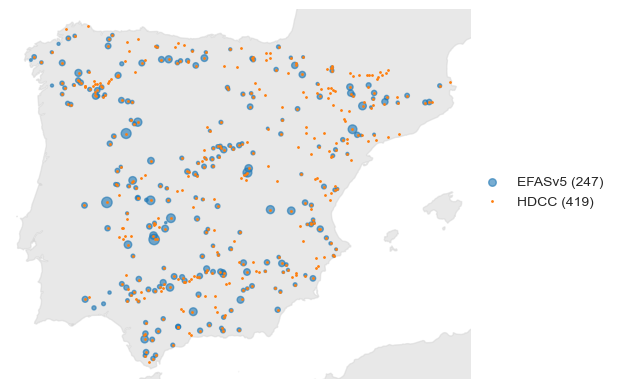

In [55]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
efas.plot(markersize=efas.Vtotal**.5, alpha=.6, ax=ax, label=f'EFASv5 ({efas.shape[0]})')
hdcc.plot(markersize=1, ax=ax, label=f'HDCC ({hdcc.shape[0]})')
# ax.set_extent([-10, 4.5, 35.5, 44])
fig.legend(frameon=False, loc=5, bbox_to_anchor=[1, .4, .1, .2])
ax.axis('off');

### Raster

In [56]:
# load static map of reservoirs
efas_raster = xr.open_mfdataset(f'{path_EFAS}/res*.nc')['res'].compute()

# extract an array of reservoir ID
# ids = np.unique(glofas_raster.where(~glofas_raster.isnull(), drop=True))
# ids = ids[~np.isnan(ids) & (ids != -9999)]
# ids = ids.astype(int)
ids = efas.index.sort_values().tolist()

# xr.DataArrays of reservoir longitudes and latitudes
lon = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
lat = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
for id in tqdm(ids):
    try:
        cell = efas_raster.where(efas_raster == id, drop=True)
        lon.loc[dict(ResID=id)] = cell.lon.data[0]
        lat.loc[dict(ResID=id)] = cell.lat.data[0]
    except:
        lon = lon.where(lon.ResID != id, drop=True)
        lat = lat.where(lat.ResID != id, drop=True)
        
coords = xr.Dataset({'lon': lon, 'lat': lat})

  0%|          | 0/247 [00:00<?, ?it/s]

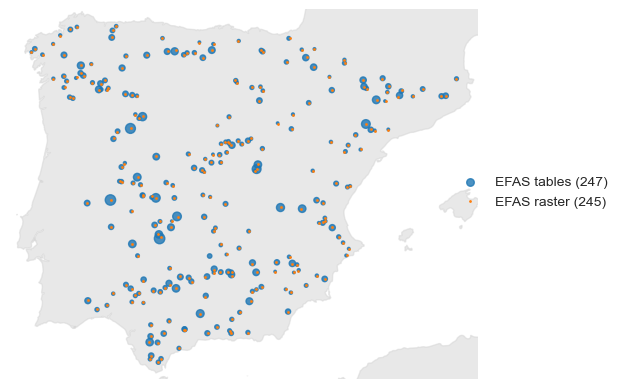

In [59]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
efas.plot(markersize=efas.Vtotal**.5, alpha=.8, ax=ax, label=f'EFAS tables ({efas.shape[0]})')
ax.scatter(coords['lon'].data, coords['lat'].data, s=1, label=f'EFAS raster ({len(coords.ResID)})')
# ax.set_extent([-10, 4.5, 35.5, 44])
fig.legend(frameon=False, loc=5, bbox_to_anchor=[1, .4, .1, .2])
# ax.set_aspect('equal')
ax.axis('off');

There's a reservoir missing in the EFAS raster (`ResID=3132`, Cenza). Apart from that, the reservoir Montoro III that I have created to replace "El Alisillo" is also missing.

### Connect HDCC and EFAS

In [62]:
# create fields for the ID and name in HDCC
efas[['Local_ID', 'HDCC_Name']] = np.nan

# find matches based on the name
mask_name = hdcc.name.isin(efas.DAM_NAME)
for ID, name in hdcc.loc[mask_name, 'name'].items():
    efas.loc[efas.DAM_NAME == name, ['Local_ID', 'HDCC_Name']] = ID, name
    # ResID = efas.loc[efas.DAM_NAME == name].index[0]
    # hdcc.loc[ID, ['ResID', 'EFAS_Name']] = ResID, name

# # find matches based on geographical proximity
# mask_id_efas = efas.Local_ID.isnull() #efas.index.difference(hdcc.ResID)
# mask_id_hdcc = hdcc.index.difference(efas.Local_ID.unique())
# idx_hdcc, idx_efas = efas.loc[mask_id_efas].sindex.nearest(hdcc.loc[mask_id_hdcc].geometry, max_distance=.025)
# idx_hdcc = hdcc.loc[mask_id_hdcc].index[idx_hdcc]
# idx_efas = efas.loc[mask_id_efas].index[idx_efas]
# efas.loc[idx_efas, ['Local_ID', 'HDCC_Name']] = idx_hdcc, hdcc.loc[idx_hdcc, 'Name'].values

# convert 'Local_ID' to integer
efas.Local_ID = efas.Local_ID.astype('Int64')

### Export

In [63]:
# reindex
efas.reset_index(inplace=True)
efas.set_index('Local_ID', drop=True, inplace=True)
efas.sort_index(inplace=True)

# rename columns
efas.rename(columns={'ACTIVE_FRO': 'YEAR'}, inplace=True)

# attributes to be included from EFAS
cols_efas = ['ResID', 'DAM_NAME', 'YEAR',
             # coordinates
             'LON_ORG', 'LAT_ORG', 'LisfloodX', 'LisfloodY',
             # LISFLOOD limits
             'Vc', 'Vf', 'Qmin', 'Qnd', 'Vn', 'Qn', 'Vtotal']

# export as CSV
# efas.loc[~efas.index.isnull(), cols_efas].to_csv(path_out / 'attributes_EFAS.csv')
efas.loc[:, cols_efas].to_csv(path_out / 'attributes_EFAS.csv')

## GRanD 

No. reservoirs:	262
No. attributes:	59


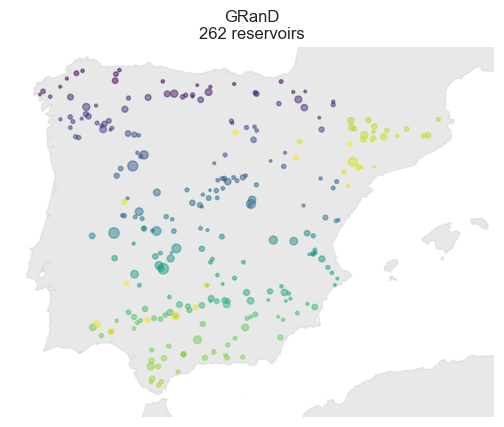

In [64]:
# load shapefile of dams
path_grand = path_datasets / 'reservoirs' / 'GRanD' / 'v1_3'
grand = gpd.read_file(path_grand / 'GRanD_dams_v1_3.shp')
grand.set_index('GRAND_ID', drop=False, inplace=True)

# filter dams in Spain
grand = grand.loc[grand.COUNTRY == 'Spain']

# correct names
grand.DAM_NAME = grand.DAM_NAME.str.upper()

print('No. reservoirs:\t{0}\nNo. attributes:\t{1}'.format(*grand.shape))

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
grand.plot(markersize=grand.CAP_MCM**.5, c=grand.MAIN_USE, cmap='viridis', alpha=.5, ax=ax)
ax.set_title(f'GRanD\n{grand.shape[0]} reservoirs')
ax.set_extent([-10, 4.5, 35.5, 44])
ax.axis('off');

### Connect HDCC and GRanD

***

In [85]:
grand[['SNCZI', 'CEDEX_name']] = np.nan
for snczi, name in tqdm(hdcc.name.items()):
    
    one = process.extractOne(name, grand.DAM_NAME, score_cutoff=80)

    if one is None:
        continue

    # compute distance
    point1 = hdcc.loc[hdcc.name == name].geometry.iloc[0]
    point2 = grand.loc[grand.DAM_NAME == one[0]].geometry.iloc[0]
    dist = geodesic((point1.y, point1.x), (point2.y, point2.x)).meters
    if dist < 1e4:
        grand.loc[grand.DAM_NAME == one[0], ['SNCZI', 'CEDEX_name']] = snczi, name
        
print('{0} matches found'.format((~grand.SNCZI.isnull()).sum()))

0it [00:00, ?it/s]

247 matches found


In [91]:
# # find matches based on geographical proximity
# mask_id_grand = grand.SNCZI.isnull()
# mask_id_hdcc = hdcc.index.difference(grand.SNCZI.unique())
# idx_hdcc, idx_grand = grand.loc[mask_id_grand].sindex.nearest(hdcc.loc[mask_id_hdcc].geometry, max_distance=.05)

# if len(idx_hdcc) > 0:
#     idx_hdcc = hdcc.loc[mask_id_hdcc].index[idx_hdcc]
#     idx_grand = grand.loc[mask_id_grand].index[idx_grand]
#     grand.loc[idx_grand, ['Local_ID', 'HDCC_Name']] = idx_hdcc, hdcc.loc[idx_hdcc, 'name'].values

# # remove SNCZI from reservoirs whose name in GRanD and HDCC doesn't match
# mask_name = grand.DAM_NAME != grand.HDCC_Name
# mask_id = ~grand.SNCZI.isnull()
# grand.loc[mask_name & mask_id, 'Local_ID'] = np.nan

In [92]:
# convert 'SNCZI' to integer
grand.SNCZI = grand.SNCZI.astype('Int64')

# reindex
grand.set_index('SNCZI', drop=True, inplace=True)

#grand.loc[mask_name, ['GRAND_ID', 'DAM_NAME', 'Local_ID', 'HDCC_Name']].head(50)

### Reservoir use

In [93]:
# rename columns
cols_use_grand = {'USE_IRRI': 'irrigation',
                     'USE_ELEC': 'hydropower',
                     'USE_SUPP': 'supply',
                     'USE_FCON': 'flood',
                     'USE_RECR': 'recreation',
                     'USE_NAVI': 'navigation',
                     'USE_FISH': 'fish',
                     'USE_PCON': 'pollution',
                     'USE_LIVE': 'livestock',
                     'USE_OTHR': 'other'}
grand.rename(columns=cols_use_grand, inplace=True)

# replace values in 'MAIN_USE' to be consistent with the columns
grand.MAIN_USE.replace({'Irrigation': 'irrigation',
                        'Hydroelectricity': 'hydropower',
                        'Water supply': 'supply',
                        'Other': 'other',
                        'Recreation': 'recreation',
                        'Flood control': 'flood'},
                       inplace=True)

# convert to boolean
grand_uses = list(cols_use_grand.values())
grand[grand_uses] = grand[grand_uses].replace({'Main': True, 'Major': True, 'Sec': True, None: False})

# identify single purpose reservoirs
grand['SINGLE_USE'] = False
mask_singleuse = grand[grand_uses].sum(axis=1) == 1
grand.loc[mask_singleuse, 'SINGLE_USE'] = True

**Main use**

In [94]:
mask_singleuse = grand.SINGLE_USE
mask_hdcc = ~grand.index.isnull()

mainuse_singlepurpose = grand.loc[mask_hdcc & mask_singleuse, 'MAIN_USE'].value_counts()
mainuse_multipurpose = grand.loc[mask_hdcc, 'MAIN_USE'].value_counts()
mainuse_summary_grand = pd.concat((mainuse_singlepurpose, mainuse_multipurpose), axis=1)
mainuse_summary_grand.columns = ['singlepurpose', 'multipurpose']
mainuse_summary_grand.sort_values('multipurpose', ascending=False, inplace=True)
del mainuse_singlepurpose, mainuse_multipurpose

**All uses**

In [95]:
alluses_singlepurpose = grand.loc[mask_hdcc & mask_singleuse, grand_uses].sum()
alluses_multipurpose = grand.loc[mask_hdcc, grand_uses].sum()
alluses_summary_grand = pd.concat((alluses_singlepurpose, alluses_multipurpose), axis=1)
alluses_summary_grand.columns = ['singlepurpose', 'multipurpose']
alluses_summary_grand.sort_values('multipurpose', ascending=False, inplace=True)
alluses_summary_grand.dropna(axis=0, how='all', inplace=True)
alluses_summary_grand = alluses_summary_grand[~(alluses_summary_grand == 0).all(axis=1)]
del alluses_singlepurpose, alluses_multipurpose

### Export

In [96]:
# attributes to be included from EFAS
cols_grand = ['GRAND_ID', 'RES_NAME', 'DAM_NAME', 'YEAR', 'REM_YEAR', 'LONG_DD', 'LAT_DD',
              'DAM_HGT_M', 'DAM_LEN_M', 'AREA_SKM', 'CAP_MCM', 'DEPTH_M', 'DIS_AVG_LS', 'DOR_PC', 'ELEV_MASL', 'CATCH_SKM',
              'irrigation', 'hydropower', 'supply', 'flood', 'recreation', 'navigation', 'fish', 'pollution', 'livestock', 'other', 'MAIN_USE', 'SINGLE_USE','LAKE_CTRL']

# export as CSV
grand.loc[~grand.index.isnull(), cols_grand].to_csv(path_out / 'attributes_GRanD.csv')
#grand.loc[:, cols_grand].to_csv(path_out / 'attributes_GRanD.csv')

## Comparison of data sets

### Reservoir volume

* CEDEX dams: `'V_MNL'`. This value does not represent total capacity, but the capacity at a normal level. Therefore, the actual reservoir capacity should always be larger than this value.
* CEDEX reservoirs: `'V_total'`, `'V_live'`
* ICOLD: `'Res_Vol'`
* EFAS: `'Vtotal'`
* GRanD: `'CAP_MCM'`

Number of reservoirs:	1273
Number of data sets:	6


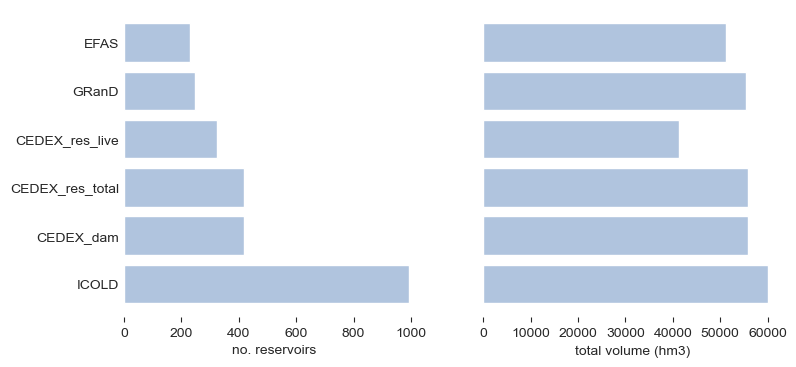

In [97]:
# combine all volume data in a single table
volume = pd.concat((cedex_dam[['V_MNL']],
                    cedex_res[['V_total', 'V_live']],
                    efas.loc[~efas.index.isnull(), 'Vtotal'],
                    grand.loc[~grand.index.isnull(), 'CAP_MCM'], 
                    icold.loc[~icold.index.isnull(), 'Res_Vol'],
                   ), axis=1)
volume.columns = ['CEDEX_dam', 'CEDEX_res_total', 'CEDEX_res_live', 'EFAS', 'GRanD', 'ICOLD']

print('Number of reservoirs:\t{0}\nNumber of data sets:\t{1}'.format(*volume.shape))

# summarize
volume_summary = pd.concat(((~volume.isnull()).sum(), volume.sum()), axis=1)
volume_summary.columns = ['no_reservoirs', 'total_volume']
volume_summary.sort_values('no_reservoirs', ascending=False, inplace=True)

# plot summary
fig, axes = plt.subplots(ncols=2, figsize=(8.5, 4), sharey=True)
for ax, col in zip(axes, volume_summary):
    ax.barh(volume_summary.index, volume_summary[col], color='lightsteelblue')
    ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
    ax.tick_params(axis='y', length=0)
    if ax == axes[0]:
        ax.set(xlabel='no. reservoirs')
    elif ax == axes[1]:
        ax.set(xlabel='total volume (hm3)')
        
plt.savefig(path_out / 'reservoir_volume_barplot.jpg', dpi=300, bbox_inches='tight');

The data in the plots above only represents the reservoirs in the datasets (EFAS, GRanD, ICOLD) that I could match with reservoirs in the HDCC database. The datasets on their own may contain more reservoirs; for instance, ICOLD includes 1066 reservoirs in Spain, but "only" 374 could be matched with the 394 reservoirs in HDCC.

EFAS and GRanD are the two data sets with fewer number of reservoirs. However, the total volume that those reservoirs represent is very close to more comprehensive data sets as ICOLD or CEDEX. Interestingly, the total volume in ICOLD slightly exceeds that in CEDEX. This could be caused by the fact that CEDEX volume does not represent total capacity, but the storage at the normal reservoir level.

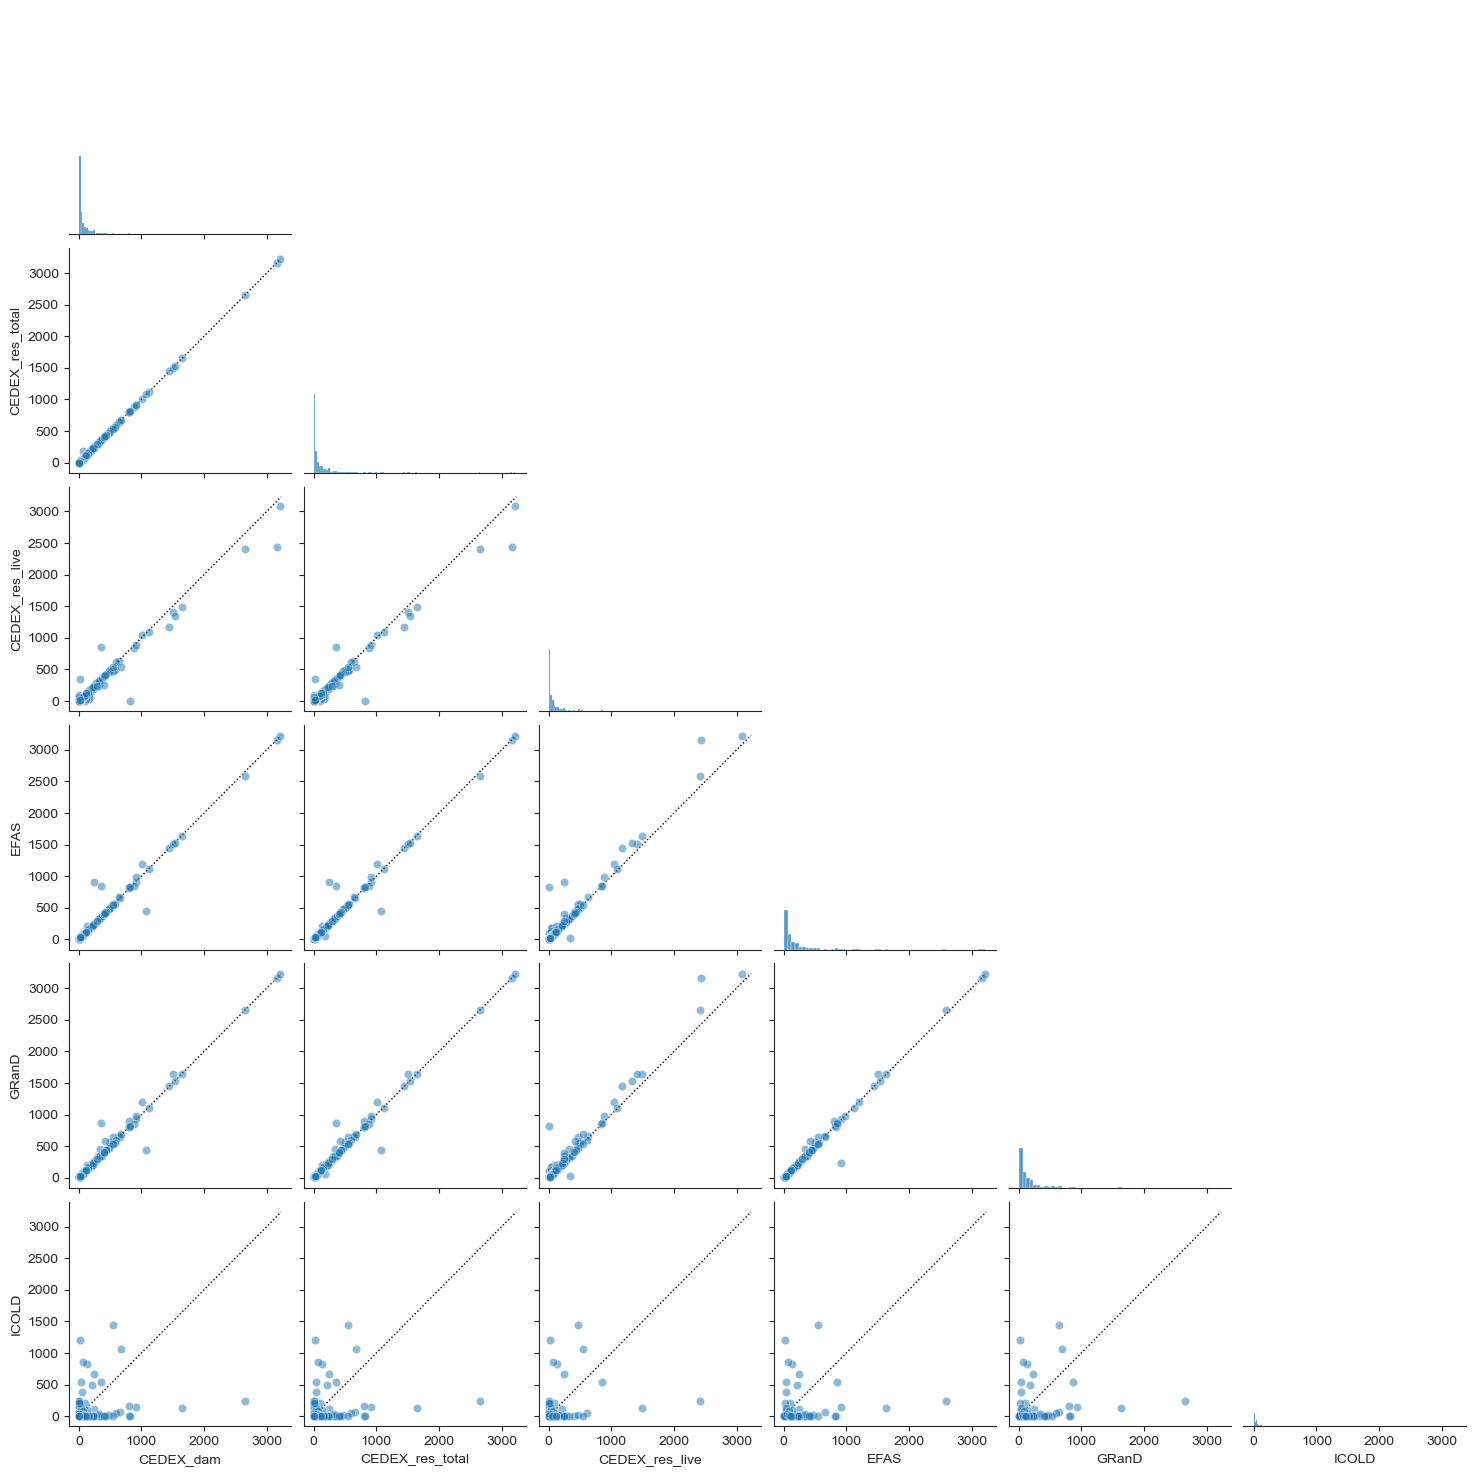

In [98]:
# pair plot
pair_plot = sns.pairplot(volume, corner=True, plot_kws={'alpha': .5})

# reference 1:1 line
nrow, ncol = pair_plot.axes.shape
vmin, vmax = volume.min().min(), volume.max().max()
for i in range(nrow):
    for j in range(ncol):
        if i > j:
            pair_plot.axes[i, j].plot([vmin, vmax], [vmin, vmax],
                                      c='k', lw=1, ls=':', zorder=0)
            
plt.savefig(path_out / 'reservoir_volume_pairplot.jpg', dpi=300, bbox_inches='tight');

I assume that CEDEX (`CEDEX_dam`) is the reference data set, as it is the local data set that probably was used by GRanD and ICOLD to develop their global data sets.

Overall, there's a good agreement between all data sets:
 * ICOLD has a few reservoirs whose storage clearly exceeds the values reported by CEDEX.
 * GRanD reservoir storage shows more deviations compared with CEDEX. This deviations are small in most cases, and both overestimate or underestimate storage.
 * As the majority of reservoirs in EFAS come from GRanD, the analysis is similar to that of GRanD.
 * The live volume in CEDEX reservoirs is obviously smaller than the normal storage in most of the cases. However, there are a couple of errors in which the live volume exceeds the normal volume.

### Reservoir surface area

All reservoir area values are in km2:

* CEDEX dams: `'A_MNL'` in ha. This value does not represent the maximum area, but the surface at a normal level.
* CEDEX reservoirs: `'AREA'`
* ICOLD: `'Res_Area'`
* EFAS: none
* GRanD: `'AREA_SKM'`

Number of reservoirs:	1273
Number of data sets:	4


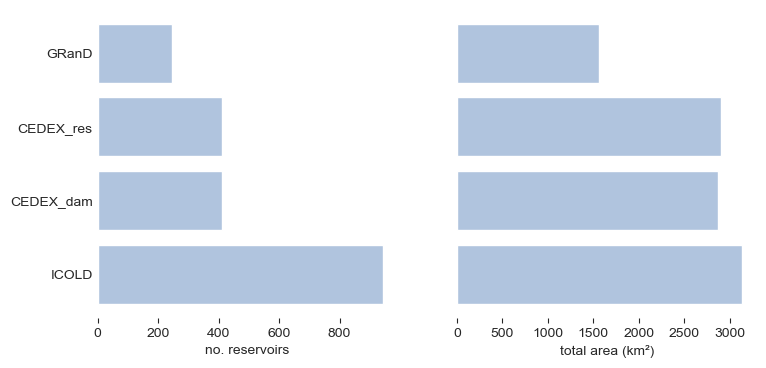

In [99]:
# combine all volume data in a single table
area = pd.concat((cedex_dam[['A_MNL']],
                  cedex_res['AREA'],
                  icold.loc[~icold.index.isnull(), 'Res_Area'],
                  # efas.loc[~efas.index.isnull(), 'Vtotal'],
                  grand.loc[~grand.index.isnull(), 'AREA_SKM'], 
                 ), axis=1)
area.columns = ['CEDEX_dam', 'CEDEX_res', 'ICOLD', 'GRanD']

print('Number of reservoirs:\t{0}\nNumber of data sets:\t{1}'.format(*area.shape))

# summarize
area_summary = pd.concat(((~area.isnull()).sum(), area.sum()), axis=1)
area_summary.columns = ['no_reservoirs', 'total_area']
area_summary.sort_values('no_reservoirs', ascending=False, inplace=True)

# plot summary
fig, axes = plt.subplots(ncols=2, figsize=(8.5, 4), sharey=True)
for ax, col in zip(axes, area_summary):
    ax.barh(area_summary.index, area_summary[col], color='lightsteelblue')
    ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
    ax.tick_params(axis='y', length=0)
    if ax == axes[0]:
        ax.set(xlabel='no. reservoirs')
    elif ax == axes[1]:
        ax.set(xlabel='total area (km²)')
        
plt.savefig(path_out / 'reservoir_area_barplot.jpg', dpi=300, bbox_inches='tight');

The values for ICOD and CEDEX are very similar, both in terms of number of reservoirs and the total reservoir area. As seen for volume, ICOLD has a slightly smaller set of reservoirs than CEDEX, but the total aggregation slightly exceeds CEDEX. Again, this could be caused by CEDEX reporting area/volume at normal reservoir level, not at its maximum level.

GRanD reports reservoir area in approximately half of the reservoirs. The total reservoir area seems to be in a similar proportion.

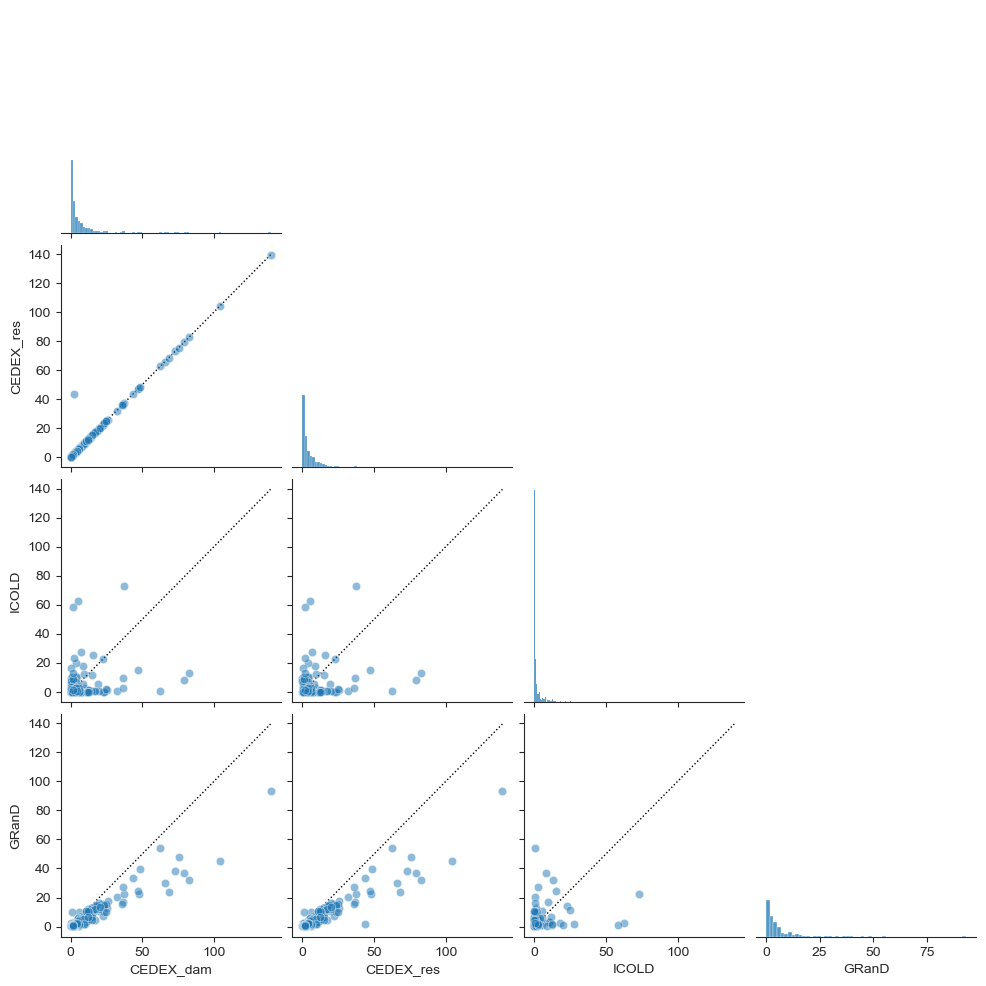

In [100]:
# pair plot
pair_plot = sns.pairplot(area, corner=True, plot_kws={'alpha': .5})

# reference 1:1 line
nrow, ncol = pair_plot.axes.shape
amin, amax = area.min().min(), area.max().max()
for i in range(nrow):
    for j in range(ncol):
        if i > j:
            pair_plot.axes[i, j].plot([amin, amax], [amin, amax],
                                      c='k', lw=1, ls=':', zorder=0)
            
plt.savefig(path_out / 'reservoir_area_pairplot.jpg', dpi=300, bbox_inches='tight');

The pair plots above show that GRanD underestimates reservoir area., and there seems to be a clear trend (even though the spread increases with increasing reservoir size).

ICOLD data agrees appropriately with CEDEX.

### Reservoir use

**Main use**

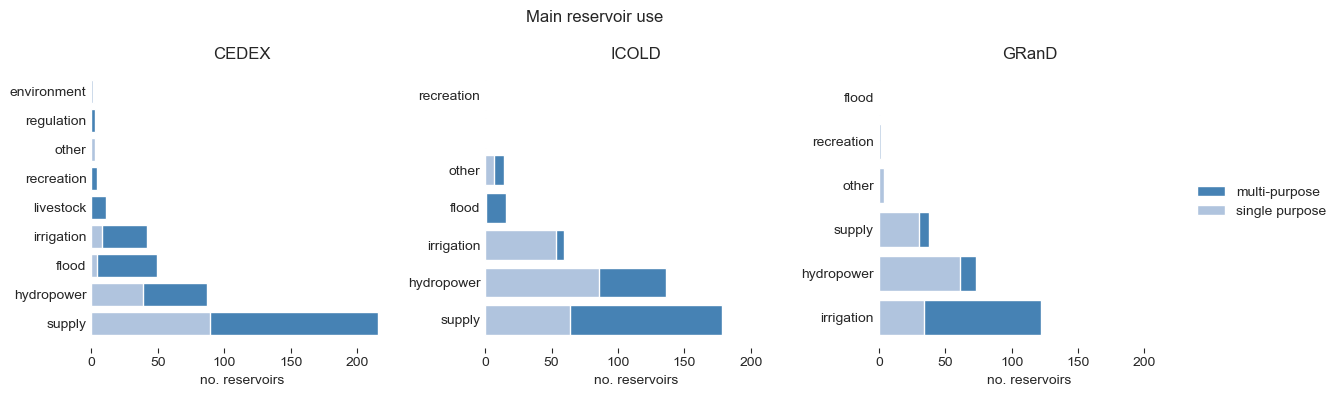

In [101]:
main_use = {'CEDEX': mainuse_summary_cedex,
            'ICOLD': mainuse_summary_icold,
            'GRanD': mainuse_summary_grand}

fig, axes = plt.subplots(ncols=len(main_use), figsize=(len(main_use) * 4, 4), sharex=True, tight_layout=True)
for ax, (label, df) in zip(axes, main_use.items()):
    ax.barh(df.index, df.multipurpose, color='steelblue', label='multi-purpose')
    ax.barh(df.index, df.singlepurpose, color='lightsteelblue', label='single purpose')
    ax.set(title=label,
           xlabel='no. reservoirs')
    ax.tick_params(axis='y', length=0)
    ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False);
fig.suptitle('Main reservoir use')
fig.legend(*ax.get_legend_handles_labels(), loc=5, frameon=False, bbox_to_anchor=[1.02, .4, .1, .2]);

plt.savefig(path_out / 'reservoir_main_use.jpg', dpi=300, bbox_inches='tight');

The definition of the main use of a reservoir is ambiguous. Is it the use that requires larger water volume? Is it a design decision? 

The ambiguity is clear in the plot above. Even though the two most common main uses (supply and hydropower) coincide in CEDEX and ICOLD, the figures differ notably. These two data sets assign different importance to flood and irrigation. On the contrary, GRanD identifies irrigation as the main reservoir use in Spain, followed by hydropower and supply; flood control has no importance in this data set.

**All uses**

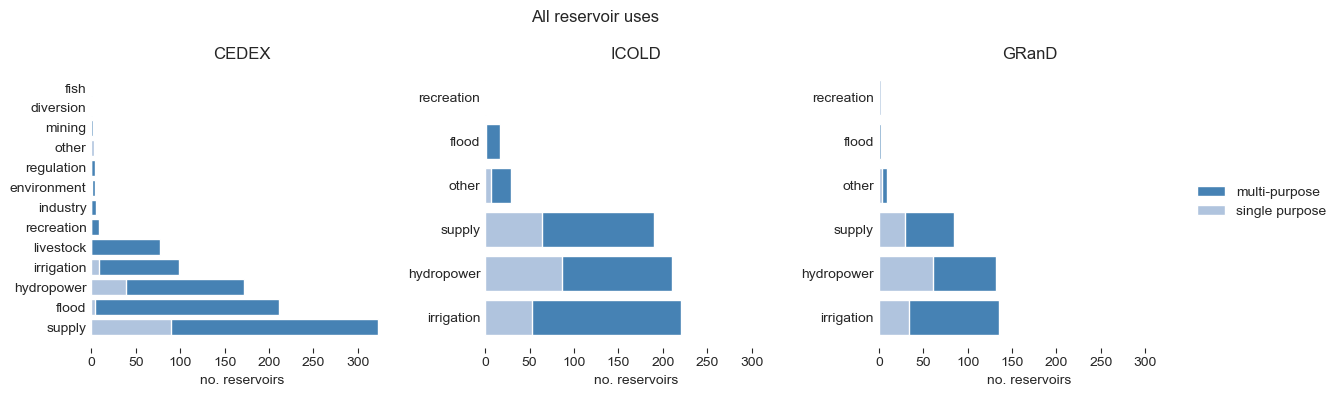

In [102]:
all_uses = {'CEDEX': alluses_summary_cedex,
            'ICOLD': alluses_summary_icold,
            'GRanD': alluses_summary_grand}

fig, axes = plt.subplots(ncols=len(all_uses), figsize=(len(all_uses) * 4, 4), sharex=True, tight_layout=True)
for ax, (label, df) in zip(axes, all_uses.items()):
    ax.barh(df.index, df.multipurpose, color='steelblue', label='multi-purpose')
    ax.barh(df.index, df.singlepurpose, color='lightsteelblue', label='single purpose')
    ax.set(title=label,
           xlabel='no. reservoirs')
    ax.tick_params(axis='y', length=0)
    ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False);
fig.suptitle('All reservoir uses')
fig.legend(*ax.get_legend_handles_labels(), loc=5, frameon=False, bbox_to_anchor=[1.02, .4, .1, .2]);

plt.savefig(path_out / 'reservoir_all_uses.jpg', dpi=300, bbox_inches='tight');

The difference between the three data sets remains when looking at all the reservoir uses. ICOLD and GRanD identify hydropower and irrigation as the two most common uses, even though the order differs between them two. CEDEX, instead, considers water supply as the main use (3rd in ICOLD and GRanD), and limits hydropower and irrigation to the 3rd and 4th rank. It's remarkable that flood control is the second most common use in CEDEX, but it has a residual value in both ICOLD and GRanD.

### Catchment area

All catchment area values are in km2?

* CEDEX dams: `'catch_area'` in ha. This value does not represent the maximum area, but the surface at a normal level.
* ICOLD: `'Catch_Area'`
* EFAS: none
* GRanD: `'CATCH_SKM'`

Number of reservoirs:	1272
Number of data sets:	3


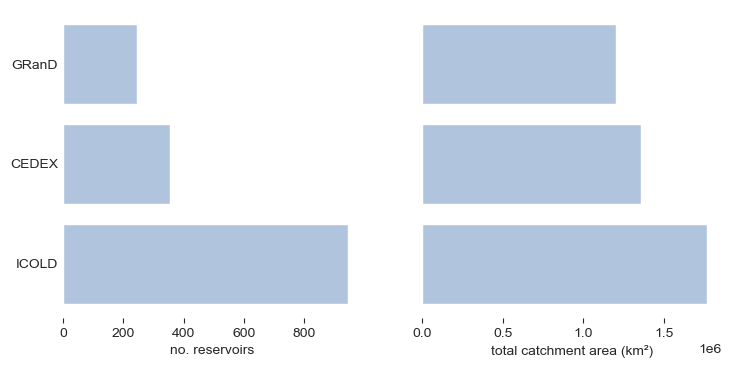

In [103]:
# combine all volume data in a single table
catchment = pd.concat((cedex_dam[['catch_area']],
                       icold.loc[~icold.index.isnull(), 'Catch_Area'],
                       grand.loc[~grand.index.isnull(), 'CATCH_SKM'], 
                      ), axis=1)
catchment.columns = ['CEDEX', 'ICOLD', 'GRanD']

print('Number of reservoirs:\t{0}\nNumber of data sets:\t{1}'.format(*catchment.shape))

# summarize
catchment_summary = pd.concat(((~catchment.isnull()).sum(), catchment.sum()), axis=1)
catchment_summary.columns = ['no_reservoirs', 'total_area']
catchment_summary.sort_values('no_reservoirs', ascending=False, inplace=True)

# plot summary
fig, axes = plt.subplots(ncols=2, figsize=(8.5, 4), sharey=True)
for ax, col in zip(axes, catchment_summary):
    ax.barh(catchment_summary.index, catchment_summary[col], color='lightsteelblue')
    ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
    ax.tick_params(axis='y', length=0)
    if ax == axes[0]:
        ax.set(xlabel='no. reservoirs')
    elif ax == axes[1]:
        ax.set(xlabel='total catchment area (km²)')
        
plt.savefig(path_out / 'reservoir_catchment_barplot.jpg', dpi=300, bbox_inches='tight');

The catchment area value is missing from several reservoirs in CEDEX, which causes that ICOLD is the most comprehensive data set. Even though the number of reservoirs in GRanD that report catchment area is notably smaller, the total catchment area is close to other data sets, meaning that GRanD includes the reservoirs with larger contributing area.

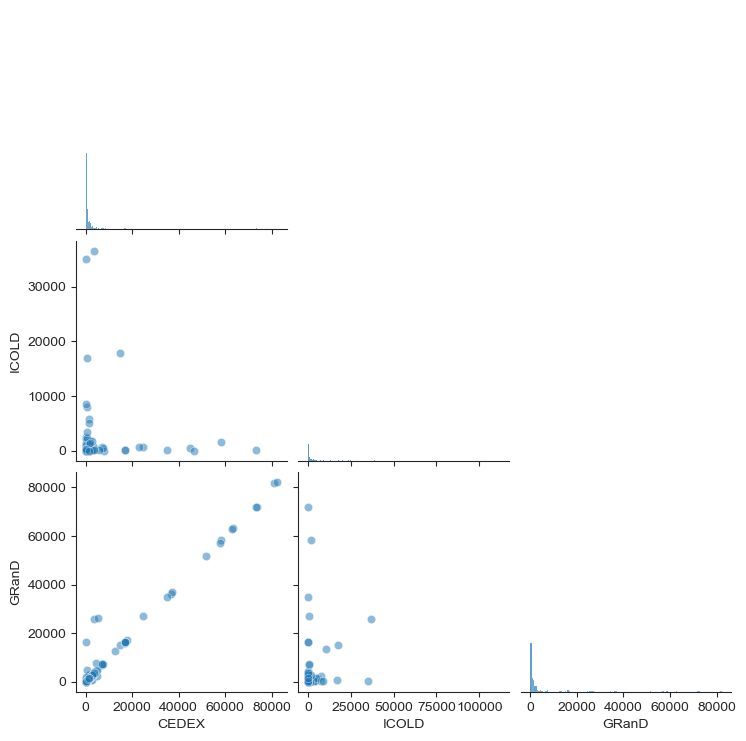

In [104]:
# pair plot
pair_plot = sns.pairplot(catchment, corner=True, plot_kws={'alpha': .5})

# reference 1:1 line
nrow, ncol = pair_plot.axes.shape
amin, amax = area.min().min(), area.max().max()
for i in range(nrow):
    for j in range(ncol):
        if i > j:
            pair_plot.axes[i, j].plot([amin, amax], [amin, amax],
                                      c='k', lw=1, ls=':', zorder=0)
            
plt.savefig(path_out / 'reservoir_catchment_pairplot.jpg', dpi=300, bbox_inches='tight');

There is a considerable scatter in the areas among the smallest catchments. Specifically, GRanD has some rerservoirs which overestimate catchment area compared both with CEDEX and ICOLD. ICOLD, instead, includes catchment areas that differ in both ways (over or underestimate) the area of small catchments compared with CEDEX.

## Conclusion

ICOLD seems to be the best data set to extract the reservoir static attributes. In the specific case of Spain, the Spanish National Inventory of Reservoirs and Dams (CEDEX) is more comprehensive, both in terms of number of reservoirs and the number of attributes). However, since this is only an exercise that must be extrapolated continentally/globally, we need to use a global data set like ICOLD or GRanD. The comparison of these two global data sets against CEDEX shows that the figures in ICOLD are closer to the reference. On top of that, I could match 374 reservoirs between the observed time series and ICOLD, and only 225 with GRanD, so using ICOLD increases notably the sample of reservoirs.